# Simulate LFP Correlation

This notebook...

NOTE: LFP data has not been attached to spontaneous blocks

## Imports

In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import neo
from neurodsp.sim.transients import sim_synaptic_kernel
from specparam import SpectralModel
import elephant.conversion as conv
import quantities as pq

import sys
sys.path.append("../../allen_vc")
from analysis import compute_psd

print("Packages Imported!")

Packages Imported!


## Settings

In [62]:
# paths
PROJECT_PATH = 'G:/Shared drives/visual_encoding'
STIM_CODE = 'natural_movie_one_more_repeats'

# spectra
FS = 1250
N_JOBS = -1
F_MIN = 2
F_MAX = 200
BANDWIDTH = 1

#specparam
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [2, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0, # (default: 0) 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2, # (default: 2.0)
    'aperiodic_mode'    :   'knee',
    'verbose'           :   False}

## Load Data

Code below is soley for testing/observation

In [63]:
# load blocks, store data

for i, file in enumerate(os.listdir(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}")):
    
    block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
    
    lfp_block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
    
    break

In [80]:
np.array(block.segments[5].filter(name='lfp')[0]).shape

(37511, 24)

In [58]:
block.segments[0]

Segment with 2 analogsignals, 50 spiketrains
annotations: {'running': False}
# analogsignals (N=2)
0: AnalogSignal with 1 channels of length 1500; units cm/s; datatype float64 
   name: 'running_speed'
   sampling rate: 50.0 Hz
   time: 4427.179999999999 s to 4457.179999999999 s
1: AnalogSignal with 1 channels of length 1500; units cm**2; datatype float64 
   name: 'pupil_area'
   sampling rate: 50.0 Hz
   time: 4427.179999999999 s to 4457.179999999999 s

## Main

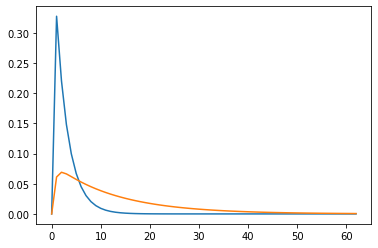

In [39]:
# create synaptic kernels based on Gao 2017

ampa = sim_synaptic_kernel(0.05, FS, 0.0001, 0.002)
gaba = sim_synaptic_kernel(0.05, FS, 0.0005, 0.010)

plt.plot(ampa)
plt.plot(gaba);

In [ ]:
# load blocks

sim_lfp_data = []

for i_file, file in enumerate(os.listdir(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}")):
    
    block = neo.io.NeoMatlabIO(f"D:/visual_encoding/data/blocks/segmented/by_cell_type/{STIM_CODE}/{file}").read_block()
    
    block_data = []
    
    # loop through epochs
    for i_seg, seg in enumerate(block.segments):
        
        # filter spikes by cell type, convert to bool array
        inhib = conv.BinnedSpikeTrain(seg.filter(cell_type='inhibitory'), binsize=(1/FS)*pq.s).to_bool_array()
        excit = conv.BinnedSpikeTrain(seg.filter(cell_type='excitatory'), binsize=(1/FS)*pq.s).to_bool_array()
        
        # summate
        inhib_spikes = np.sum(inhib, axis=1)
        excit_spikes = np.sum(excit, axis=1)
        
        # convolve
        inhib_lfp = np.convolve(inhib_spikes, gaba, 'valid')
        excit_lfp = np.convolve(excit_spikes, ampa, 'valid')
        
        # summate
        sim_lfp = inhib_lfp + excit_lfp
        
        # compute correlation with actual lfp
        lfp = np.array(seg.filter(name='lfp')[0]).mean(axis=1) # which channels?
        corr = np.corrcoef(sim_lfp, lfp)
        
        
        # compute spectral power
        spectra, freq = compute_psd(sim_lfp, FS, fmin=F_MIN, fmax=F_MAX, bandwidth=BANDWIDTH,
                                    n_jobs=N_JOBS, verbose=False)
        
        # compute specparam metrics
        fm = SpectralModel(**SPEC_PARAM_SETTINGS)
        fm.fit(freq, spectra)
        params = fm.aperiodic_params
        
        block_data.append(params + [corr])
        
    # create dataframe
    df = pd.DataFrame(block_data, columns=['offset', 'knee', 'exponent', 'sim_corr', 'epoch_idx'])
    df['session'] = file.split('_')[1].split('.')[0]
    sim_lfp_data.append(df)
    
# concatenate
sim_lfp_df = pd.concat(sim_lfp_data)

# save
# sim_lfp_df.to_csv(f'D:/visual_encoding/data/lfp_data/sim/sim_lfp_{STIM_CODE}.csv',index=False)

In [ ]:
# plot examples with actual LFP side by side


In [ ]:
# plot correlation coefficient distribution


In [ ]:
# plot specparams
